# Video Game Genre Prediction

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import utils
from sklearn.metrics import classification_report

import os, PIL
from glob import glob

import tensorflow as tf

print(tf.__version__)

2.6.0


In [3]:
""" Sequential Model Architecture """
Sequential = tf.keras.models.Sequential

""" Data Preprocessing Functions """
Resizing = tf.keras.layers.experimental.preprocessing.Resizing
Rescaling = tf.keras.layers.experimental.preprocessing.Rescaling

""" Data Augmentation Functions """
RandomFlip = tf.keras.layers.experimental.preprocessing.RandomFlip
RandomRotation = tf.keras.layers.experimental.preprocessing.RandomRotation
RandomZoom = tf.keras.layers.experimental.preprocessing.RandomZoom

""" Artificial Neural Network Layer Inventory """
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

""" Convolutional Neural Network Layer Inventory """
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D
Flatten = tf.keras.layers.Flatten

""" Residual Network Layer Inventory """
ResNet50 = tf.keras.applications.resnet50.ResNet50

""" Function to Load Images from Target Folder """
image_dataset_from_directory = tf.keras.preprocessing.image_dataset_from_directory

In [4]:
DATA_DIRECTORY = "dataset/"
FIGHTING_GENRE_COVERS = f"{DATA_DIRECTORY}/fighting/*"
INDIE_GENRE_COVERS = f"{DATA_DIRECTORY}/indie/*"
PLATFORM_GENRE_COVERS = f"{DATA_DIRECTORY}/platform/*"
PUZZLE_GENRE_COVERS = f"{DATA_DIRECTORY}/puzzle/*"
SPORT_GENRE_COVERS = f"{DATA_DIRECTORY}/indie/*"

print(f"{len(glob(FIGHTING_GENRE_COVERS))} Fighting Game Covers")
print(f"{len(glob(INDIE_GENRE_COVERS))} Indie Game Covers")
print(f"{len(glob(PLATFORM_GENRE_COVERS))} Platform Game Covers")
print(f"{len(glob(PUZZLE_GENRE_COVERS))} Puzzle Game Covers")
print(f"{len(glob(SPORT_GENRE_COVERS))} Sport Game Covers")

1000 Fighting Game Covers
1000 Indie Game Covers
1000 Platform Game Covers
1000 Puzzle Game Covers
1000 Sport Game Covers


In [5]:
batch_size = 32
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [143]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

train = image_dataset_from_directory(
    directory=DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size
)

validation = image_dataset_from_directory(
    directory=DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size
)

class_names = train.class_names
print(class_names)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.
['fighting', 'indie', 'platform', 'puzzle', 'sport']


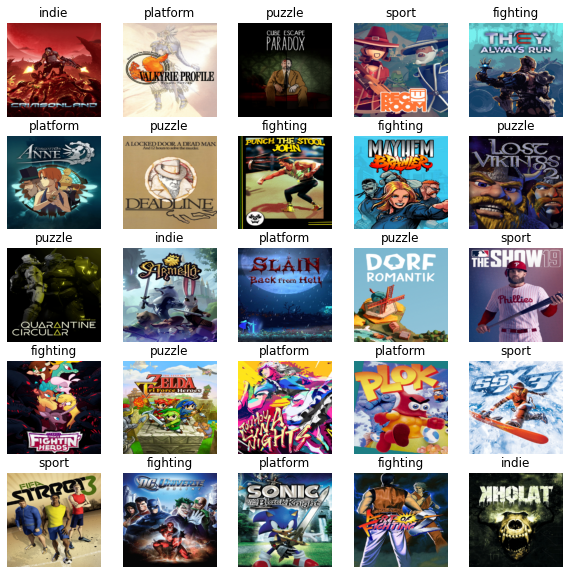

In [160]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [144]:
train = train.cache().shuffle(4000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [145]:
input_tensor = tf.keras.Input(shape=(224,224,3))
resnet_model = ResNet50(include_top=False, weights="resnet50_weights.h5", input_tensor=input_tensor)

In [146]:
for layer in resnet_model.layers[:143]:
    layer.trainable = False

for i, layer in enumerate(resnet_model.layers):
    print(i, layer.name, "Trainable: ", layer.trainable)

0 input_14 Trainable:  False
1 conv1_pad Trainable:  False
2 conv1_conv Trainable:  False
3 conv1_bn Trainable:  False
4 conv1_relu Trainable:  False
5 pool1_pad Trainable:  False
6 pool1_pool Trainable:  False
7 conv2_block1_1_conv Trainable:  False
8 conv2_block1_1_bn Trainable:  False
9 conv2_block1_1_relu Trainable:  False
10 conv2_block1_2_conv Trainable:  False
11 conv2_block1_2_bn Trainable:  False
12 conv2_block1_2_relu Trainable:  False
13 conv2_block1_0_conv Trainable:  False
14 conv2_block1_3_conv Trainable:  False
15 conv2_block1_0_bn Trainable:  False
16 conv2_block1_3_bn Trainable:  False
17 conv2_block1_add Trainable:  False
18 conv2_block1_out Trainable:  False
19 conv2_block2_1_conv Trainable:  False
20 conv2_block2_1_bn Trainable:  False
21 conv2_block2_1_relu Trainable:  False
22 conv2_block2_2_conv Trainable:  False
23 conv2_block2_2_bn Trainable:  False
24 conv2_block2_2_relu Trainable:  False
25 conv2_block2_3_conv Trainable:  False
26 conv2_block2_3_bn Trainable:

In [9]:
resizing_layer = Resizing(IMAGE_HEIGHT, IMAGE_WIDTH)
normalization_layer = tf.keras.layers.BatchNormalization()

input_layer = tf.keras.layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

flatten_layer = Flatten()

dropout_layer = Dropout(0.5)

dense_layer_1 = Dense(256, activation="relu")
dense_layer_2 = Dense(128, activation="relu")
dense_layer_3 = Dense(64, activation="relu")
output_layer = Dense(1, activation="sigmoid")

model = Sequential()

model.add(input_layer)
model.add(resizing_layer)
model.add(resnet_model)
model.add(flatten_layer)
model.add(normalization_layer)
model.add(dense_layer_1)
model.add(dropout_layer)
model.add(dense_layer_2)
model.add(dropout_layer)
model.add(dense_layer_3)
model.add(dropout_layer)
model.add(output_layer)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="model/genre_model.h5",
                                                monitor="val_accuracy",
                                                mode="max",
                                                save_best_only=True)

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [23]:
history = model.fit(train, validation_data=validation, callbacks=[checkpoint], epochs=5)

Epoch 1/5
  2/125 [..............................] - ETA: 5:22 - loss: 0.0000e+00 - accuracy: 0.1562 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [13]:
model.evaluate(validation)

32/32 [==============================] - 60s 2s/step - loss: 0.0000e+00 - accuracy: 0.1910


[0.0, 0.19099999964237213]

In [15]:
model.save("model/genre_model.h5")

/Users/kou/dev/courses/acs3520/Fire-Detection-API-Project/env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Tuning and Making Improvements

In [147]:
resizing_layer = Resizing(IMAGE_HEIGHT, IMAGE_WIDTH)
normalization_layer = tf.keras.layers.BatchNormalization()

input_layer = tf.keras.layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

flatten_layer = Flatten()

dropout_layer = Dropout(0.5)

dense_layer_1 = Dense(256, activation="relu")
dense_layer_2 = Dense(128, activation="relu")
dense_layer_3 = Dense(64, activation="relu")
output_layer = Dense(5, activation="softmax")

model = Sequential()

model.add(input_layer)
model.add(resizing_layer)
model.add(resnet_model)
model.add(flatten_layer)
model.add(normalization_layer)
model.add(dense_layer_1)
model.add(dropout_layer)
model.add(dense_layer_2)
model.add(dropout_layer)
model.add(dense_layer_3)
model.add(dropout_layer)
model.add(output_layer)

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_32 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)              

In [148]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="model/genre_model.h5",
                                                monitor="val_accuracy",
                                                mode="max",
                                                save_best_only=True)

In [151]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [152]:
history = model.fit(train, validation_data=validation, callbacks=[checkpoint], epochs=5)

Epoch 1/5
125/125 [==============================] - 434s 3s/step - loss: 7.3163 - accuracy: 0.2253 - val_loss: 6.4201 - val_accuracy: 0.2490


/Users/kou/dev/courses/acs3520/Fire-Detection-API-Project/env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
125/125 [==============================] - 414s 3s/step - loss: 2.9728 - accuracy: 0.2135 - val_loss: 1.6110 - val_accuracy: 0.2000
Epoch 3/5
125/125 [==============================] - 406s 3s/step - loss: 1.9586 - accuracy: 0.2160 - val_loss: 1.6109 - val_accuracy: 0.2020
Epoch 4/5
125/125 [==============================] - 395s 3s/step - loss: 1.7869 - accuracy: 0.2138 - val_loss: 1.6105 - val_accuracy: 0.2040
Epoch 5/5
125/125 [==============================] - 398s 3s/step - loss: 1.6980 - accuracy: 0.2105 - val_loss: 1.6105 - val_accuracy: 0.1890


In [153]:
resizing_layer = Resizing(IMAGE_HEIGHT, IMAGE_WIDTH)
normalization_layer = tf.keras.layers.BatchNormalization()

input_layer = tf.keras.layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
flip_layer = RandomFlip(mode="horizontal_and_vertical")
rotation_layer = RandomRotation(factor=0.2, fill_mode="nearest")
zoom_layer = RandomZoom(height_factor=0.2, width_factor=0.3, fill_mode="nearest")

augmentation_layer = Sequential([flip_layer, rotation_layer, zoom_layer])

flatten_layer = Flatten()

dropout_layer = Dropout(0.3)

dense_layer_1 = Dense(256, activation="relu")
dense_layer_2 = Dense(128, activation="relu")
dense_layer_3 = Dense(64, activation="relu")
output_layer = Dense(5, activation="softmax")

model = Sequential()

model.add(input_layer)
model.add(augmentation_layer)
model.add(resizing_layer)
model.add(resnet_model)
model.add(flatten_layer)
model.add(normalization_layer)
model.add(dense_layer_1)
model.add(dropout_layer)
model.add(dense_layer_2)
model.add(dropout_layer)
model.add(dense_layer_3)
model.add(dropout_layer)
model.add(output_layer)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="model/genre_model.h5",
                                                monitor="val_accuracy",
                                                mode="max",
                                                save_best_only=True)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train, validation_data=validation, callbacks=[checkpoint], epochs=5)

Epoch 1/5
125/125 [==============================] - 397s 3s/step - loss: 2.6097 - accuracy: 0.2280 - val_loss: 3.7661 - val_accuracy: 0.2490


/Users/kou/dev/courses/acs3520/Fire-Detection-API-Project/env/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
125/125 [==============================] - 395s 3s/step - loss: 1.7033 - accuracy: 0.2495 - val_loss: 1.6380 - val_accuracy: 0.2620
Epoch 3/5
125/125 [==============================] - 396s 3s/step - loss: 1.6057 - accuracy: 0.2530 - val_loss: 1.8876 - val_accuracy: 0.3110
Epoch 4/5
125/125 [==============================] - 435s 3s/step - loss: 1.5638 - accuracy: 0.2822 - val_loss: 1.6347 - val_accuracy: 0.3140
Epoch 5/5
125/125 [==============================] - 452s 4s/step - loss: 1.5510 - accuracy: 0.3050 - val_loss: 1.6448 - val_accuracy: 0.3270


In [154]:
model.evaluate(validation)

32/32 [==============================] - 65s 2s/step - loss: 1.6448 - accuracy: 0.3270


[1.6447638273239136, 0.3269999921321869]

In [155]:
model.save("model/genre_model.h5")

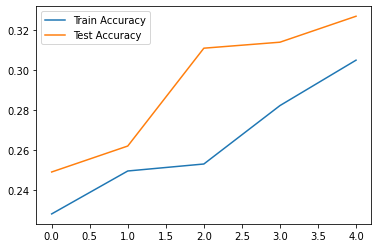

In [164]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.legend()
plt.show()

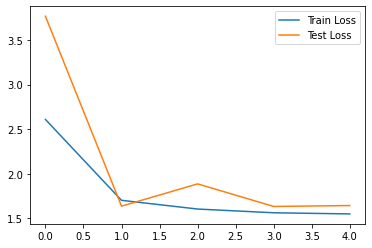

In [167]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.legend()
plt.show()